In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# Download Penn Treebank dataset
import urllib.request
import os

# Create data directory if it doesn't exist
os.makedirs('data/ptb', exist_ok=True)

# Penn Treebank URLs
ptb_urls = {
    'train': 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt',
    'valid': 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt',
    'test': 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt'
}

# Download files
for split, url in ptb_urls.items():
    filepath = f'data/ptb/ptb.{split}.txt'
    if not os.path.exists(filepath):
        print(f'Downloading {split} data...')
        urllib.request.urlretrieve(url, filepath)
        print(f'Saved to {filepath}')
    else:
        print(f'{split} data already exists at {filepath}')

train data already exists at data/ptb/ptb.train.txt
valid data already exists at data/ptb/ptb.valid.txt
test data already exists at data/ptb/ptb.test.txt


In [3]:
# Load and tokenize the data
def load_ptb_data(filepath):
    """Load PTB data and return list of words"""
    with open(filepath, 'r') as f:
        # PTB has one sentence per line, words separated by spaces
        # <unk> is used for unknown words, <eos> marks end of sentence
        text = f.read()
        words = text.split()
    return words

# Load all splits
train_words = load_ptb_data('data/ptb/ptb.train.txt')
valid_words = load_ptb_data('data/ptb/ptb.valid.txt')
test_words = load_ptb_data('data/ptb/ptb.test.txt')

print(f'Train: {len(train_words)} words')
print(f'Valid: {len(valid_words)} words')
print(f'Test: {len(test_words)} words')
print(f'\nFirst 50 words: {train_words[:50]}')

Train: 887521 words
Valid: 70390 words
Test: 78669 words

First 50 words: ['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group']


In [7]:
def build_vocabulary(words):
    words_set = set(words)
    word_to_idx = {word: i for i, word in enumerate(words_set)}
    idx_to_word = {i: word for (word, i) in word_to_idx.items()}

    return word_to_idx, idx_to_word

In [8]:
word_to_idx, idx_to_word = build_vocabulary(train_words+valid_words+test_words)
Vsize = len(word_to_idx)

In [9]:
Vsize

9999

In [10]:
context_len = 4
def build_dataset(words):
    X, Y = [], []
    for i in range(len(words) - context_len - 1):
        ctxi = [word_to_idx[words[i+j]] for j in range(context_len)]
        target = word_to_idx[words[i+context_len]]
        
        X.append(ctxi)
        Y.append(target)
    
    return torch.tensor(X),torch.tensor(Y)


In [11]:
trainX, trainY = build_dataset(train_words)
devX, devY = build_dataset(valid_words)
testX, testY = build_dataset(test_words)

In [12]:
trainX.shape

torch.Size([887516, 4])

In [19]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        k = 1.0 / math.sqrt(in_features)
        self.W = (2*k) * torch.rand((out_features, in_features)) - k #Sampled uniformaly between [-1/sqrt(k), 1/sqrt(k)] 
        self.b = None
        if bias:
            self.b = (2*k) * torch.rand(out_features) - k
    
    def __call__(self, x):
        out = x @ self.W.T 
        if self.b is not None:  
            return out + self.b
        return out
    
    def parameters(self):
        return [self.W, self.b] if self.b is not None else [self.W]

class Tanh:
    def __init__(self):
        self.out = None

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self,num_features, eps=1e-05, momentum=0.1, training=True):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = eps
        self.momentum = momentum
        self.training=training
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
    
    def __call__(self,x: torch.Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / (torch.sqrt(xvar+ self.eps))
        out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum*xvar
        
        return out
    
    def parameters(self):
        return [self.gamma, self.beta]








In [20]:
n_embed = 10 # Embedding space size
n_hidden = 100 # Number of neurons in a single hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((Vsize, 10), generator=g) #Embedding layer
layers = [
    Linear(n_embed * context_len, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, Vsize, False), BatchNorm1d(Vsize), 
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad  = True


1124088


In [21]:
def compute_loss(X, Y):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False

    with torch.no_grad():
        batch_size = 10_000
        losses = []
        for i in range(0, len(X), batch_size):
            Xi, Yi = X[i:i+batch_size], Y[i:i+batch_size]
            emb = C[Xi] # (batch_size, context_len, 10)
            x = emb.view(emb.shape[0], -1) # (887517, 30)
            for layer in layers:
                x = layer(x)
            loss = F.cross_entropy(x, Yi) # Softmax & cross entropy loss 
            losses.append(loss.item())
        
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = True

    return sum(losses)/len(losses)

In [22]:
import torch.nn.functional as F
batch_size = 256
base_lr = 0.1
max_steps = 200_000
lossi = []
ud = []

for i in range(max_steps):
    #Forward pass
    ix = torch.randint(trainX.shape[0], (batch_size,), generator=g)
    Xb, Yb = trainX[ix], trainY[ix] # Batch 
    emb = C[Xb] # (887516, 4, 10)
    x = emb.view(emb.shape[0], -1) # (887516, 40)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb) # Softmax & cross entropy loss compute

    for p in parameters:
        p.grad = None
    
    # Compute gradients
    loss.backward()

    # Update parameters
    lr = base_lr if i < 150_000 else base_lr * 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
 
print(f"train loss: {loss.item():.4f}")
print(f"dev loss: {compute_loss(devX, devY):.4f}")
print(f"test loss: {compute_loss(testX, testY):.4f}")
    

      0/ 200000: 9.7793
   1000/ 200000: 7.9051


/var/folders/84/63jpsk2x2f54zgzd4z_kbczm0000gn/T/ipykernel_81925/1259283249.py:7: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.64%


Text(0.5, 1.0, 'activation distribution')

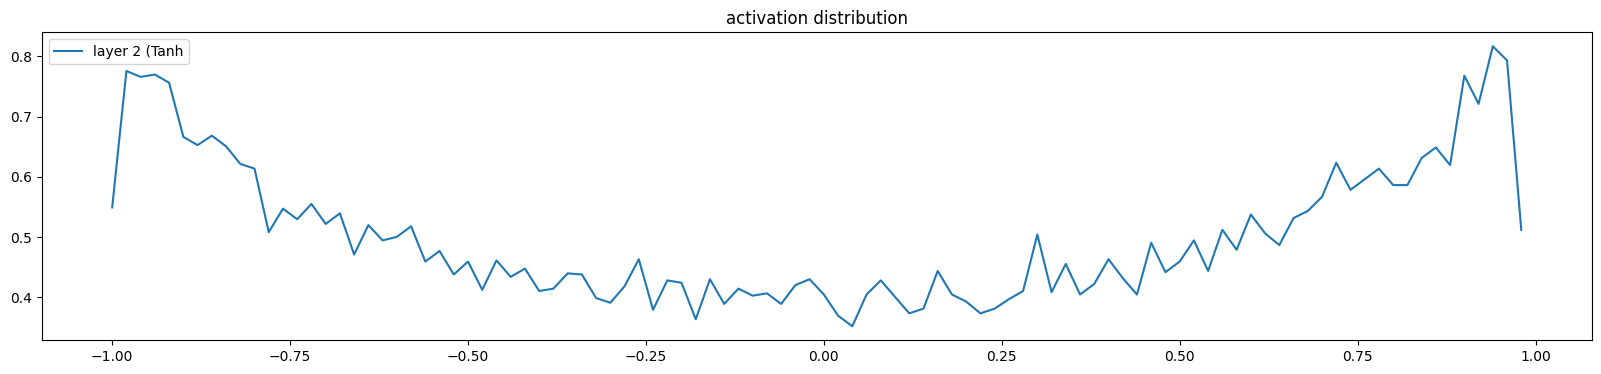

In [23]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

with torch.no_grad():
    for _ in range(10):  # Generate 10 sequences
        out = []
        # Start with 3 random words from vocabulary
        context = torch.randint(0, Vsize, (4,), generator=g).tolist()
        
        for _ in range(20):  # Generate up to 50 words

            # Forward pass
            emb = C[torch.tensor([context])]  # (1, 4, 10)
            x = emb.view(1, -1)
            
            for layer in layers:
                x = layer(x)

            probs = F.softmax(x, dim=1)  #(1, Vsize)
            
            # Sample next word
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            out.append(idx_to_word[ix])
            
            # Update context window (sliding window)
            context = context[1:] + [ix]
        
        print(' '.join(out))


for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = True

news commission vetoed but a truly image following a $ N million of <unk> <unk> a homeless and weyerhaeuser co.
is thought to be excellent at the split 's <unk> and electronics instruments call but is their jitters on the
displays warner <unk> president of the delegation of crown technical contribution was sensitive to listen to beverage furs on u.s.
or high futures is considering such <unk> state as a response to coats airline this british depositary shares were in
<unk> of goods from unidentified items he said her remarks burned by international express tom <unk> president and a two
at other property dealers had to engineers the <unk> light if people do n't know how the boys quit of
companies which moved on the market despite long although potential costs to six months in october was a book value
in the national association and nynex corp. account manager mr. pilson many of the scientists ' crusaders and recent <unk>
is in school charles mullins a <unk> after he believes the great ju